In [289]:
import eotdl

print(eotdl.__version__)


2025.04.22-3


In this notebook we generate the dataset for the use case

1. Generate list of Satellogic images to be used (containing bb and acquisition time)
2. Explore available S1/S2 images with different criteria
	- bounding box overlap
	- acquisition time overlap
3. Download matching S1/S2 at given resolution
4. Generate metadata and ingest to EOTDL 

In [290]:
import geopandas as gpd

gdf = gpd.read_parquet('~/Desktop/EarthPulse_Local_Data/data/satellogic-earthview-items-with-matches.parquet')
# gdf = gpd.read_parquet('~/DeLocal_Data/satellogic-earthview-items-with-matches.parquet')
# json_path, zone, region, date, geometry, matches
# json_path, zone, region, date, geometry
gdf.head()


,json_path,zone,region,date,geometry,s1_matches,s2_matches
0,data/json/zone=29N/region=745414_4173395/date=...,29N,745414_4173395,2022-08-19,"POLYGON ((-6.21307 37.67139, -6.21294 37.67485...",[{'id': 'S1A_IW_GRDH_1SDV_20220822T182718_2022...,[{'id': 'S2B_MSIL2A_20220819T110619_N0400_R137...
1,data/json/zone=50S/region=712508_7510599/date=...,50S,712508_7510599,2022-10-04,"POLYGON ((119.06952 -22.50128, 119.06947 -22.4...",[],[{'id': 'S2A_MSIL2A_20221005T020451_N0400_R017...
2,data/json/zone=41N/region=432519_3707745/date=...,41N,432519_3707745,2022-08-13,"POLYGON ((62.27761 33.50368, 62.27758 33.50715...",[{'id': 'S1A_IW_GRDH_1SDV_20220814T015645_2022...,[{'id': 'S2B_MSIL2A_20220815T062629_N0400_R077...
3,data/json/zone=21S/region=762452_6176533/date=...,21S,762452_6176533,2022-10-27,"POLYGON ((-54.13661 -34.52281, -54.13673 -34.5...",[{'id': 'S1A_IW_GRDH_1SDV_20221030T085904_2022...,[{'id': 'S2A_MSIL2A_20221029T133151_N0400_R081...
4,data/json/zone=55S/region=689273_6113407/date=...,55S,689273_6113407,2022-12-10,"POLYGON ((149.08097 -35.10778, 149.08088 -35.1...",[{'id': 'S1A_IW_GRDH_1SDV_20221213T192427_2022...,[{'id': 'S2B_MSIL2A_20221210T000219_N0509_R030...


In [291]:
gdf.shape

(10, 7)

In [292]:
gdf['num_s1_matches'] = gdf.s1_matches.apply(len)
gdf['num_s1_matches'].value_counts()

gdf['num_s2_matches'] = gdf.s2_matches.apply(len)
gdf['num_s2_matches'].value_counts()

num_s2_matches
2    4
3    2
4    2
1    2
Name: count, dtype: int64

In [293]:
# find sample with s1 and s2 matches
from find_matches import NUM_SAMPLES
from download_images import filter_clouds

samples = gdf.sample(NUM_SAMPLES, replace=False)
sample = None

s1_matches, s2_matches = [], []
for r, _sample in samples.iterrows():
	s1_matches, s2_matches = _sample.s1_matches, _sample.s2_matches

	if len(s1_matches) <= 0 or len(s2_matches) <= 0:
		continue
		
	sample = _sample
	break

print(f"s1_matches: {[match['id'] for match in s1_matches]}")
print(f"s2_matches: {[match['id'] for match in s2_matches]}\n")


s1_matches: ['S1A_IW_GRDH_1SDV_20220814T015645_20220814T015710_044542_0550E9_F19B', 'S1A_IW_GRDH_1SDV_20220813T135438_20220813T135503_044535_0550A0_E757']
s2_matches: ['S2B_MSIL2A_20220815T062629_N0400_R077_T41SMT_20220815T081541', 'S2A_MSIL2A_20220813T063641_N0400_R120_T41SMT_20220813T103103', 'S2A_MSIL2A_20220810T062641_N0400_R077_T41SMT_20220810T110156']



In [294]:
from eotdl.tools import bbox_from_centroid
from eotdl.access import download_sentinel_imagery
from download_images import download_sat_image
import shutil
import os

WIDTH = 38
HEIGHT = 38

# Remove and recreate the sample folder structure
shutil.rmtree('sample', ignore_errors=True)
os.makedirs('sample/satellogic', exist_ok=True)
os.makedirs('sample/sentinel1', exist_ok=True)
os.makedirs('sample/sentinel2', exist_ok=True)

print("collecting...")

# Prepare sample details
date = sample.date
json_path = sample.json_path
centroid = sample.geometry.centroid

# Base name for all files
base_name = json_path.split('/')[-1].replace('_metadata.json', '')
print(f"base name: {base_name}")
satellogic_name = f"{base_name}_TOA.tif"
sent1_name = f"{base_name}_S1GRD.tiff"
sent2_name = f"{base_name}_S2L2A.tiff"

# Source directory (local dataset location)
local_data_path = os.path.expanduser("~/Desktop/EarthPulse_Local_Data/data")

# Source paths
src_sat = f"{local_data_path}/tifs/satellogic/{satellogic_name}"
src_s1 = f"{local_data_path}/tifs/sentinel1/{sent1_name}"
src_s2 = f"{local_data_path}/tifs/sentinel2/{sent2_name}"

# Destination paths
dst_sat = f"sample/satellogic/{satellogic_name}"
dst_s1 = f"sample/sentinel1/{sent1_name}"
dst_s2 = f"sample/sentinel2/{sent2_name}"

# Perform the copies
shutil.copy2(src_sat, dst_sat)
if os.path.exists(src_s1):
	shutil.copy2(src_s1, dst_s1)
if os.path.exists(src_s2):
	shutil.copy2(src_s2, dst_s2)

print("All files copied successfully.")
    

collecting...
base name: 20220813_102958_SN20_41N_432519_3707745
All files copied successfully.


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


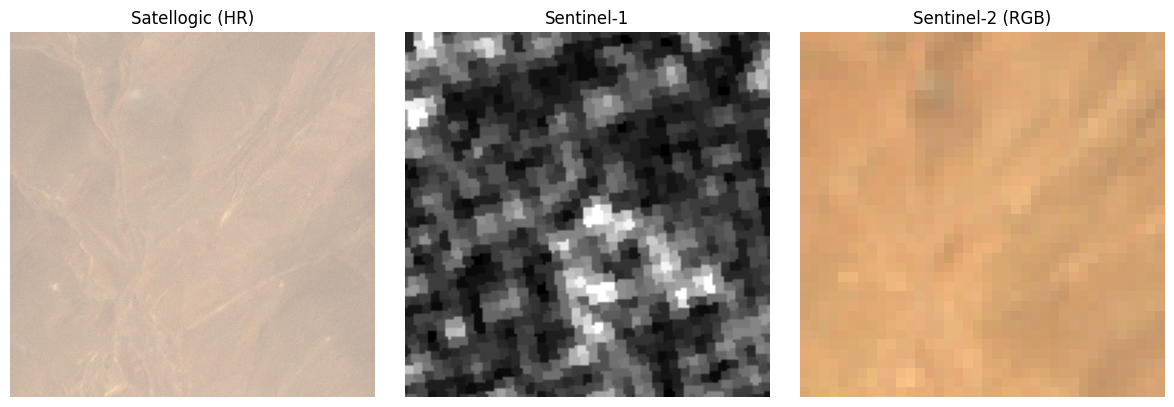

In [295]:
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Satellogic (HR)
axs[0].imshow((rio.open(dst_sat).read()[:3, ...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[0].set_title("Satellogic (HR)")
axs[0].axis('off')

if os.path.exists(dst_s2):
	# Sentinel-2 (RGB: bands 4, 3, 2)
	axs[2].imshow((rio.open(dst_s2).read()[(3, 2, 1), ...].transpose(1, 2, 0) / 3000).clip(0, 1))
axs[2].set_title("Sentinel-2 (RGB)")
axs[2].axis('off')

if os.path.exists(dst_s1):
	# Sentinel-1 (bands 3, 2, 1 if available; fallback to band 1 grayscale)
	with rio.open(dst_s1) as src:
		band = src.read(1).astype(np.float32)
	
		# Optional: remove very high outliers for better contrast
		band = np.clip(band, 0, np.percentile(band, 99))
	
		# Normalize to 0–1
		band = (band - band.min()) / (band.max() - band.min() + 1e-5)

axs[1].imshow(band, cmap='gray')
axs[1].set_title("Sentinel-1 (normalized)")
axs[1].axis('off')

axs[1].set_title("Sentinel-1")
axs[1].axis('off')

plt.tight_layout()
plt.show()


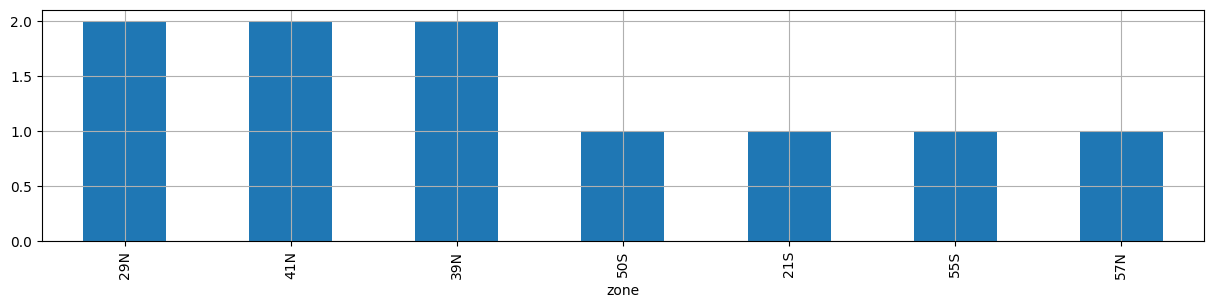

In [296]:
import matplotlib.pyplot as plt


# plot histogram with number of images per zone
fig = plt.figure(figsize=(15, 3))
gdf['zone'].value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [297]:
len(gdf['zone'].unique()), len(gdf['region'].unique())

(7, 10)

In [298]:
gdf['zone'].value_counts().min()

np.int64(1)

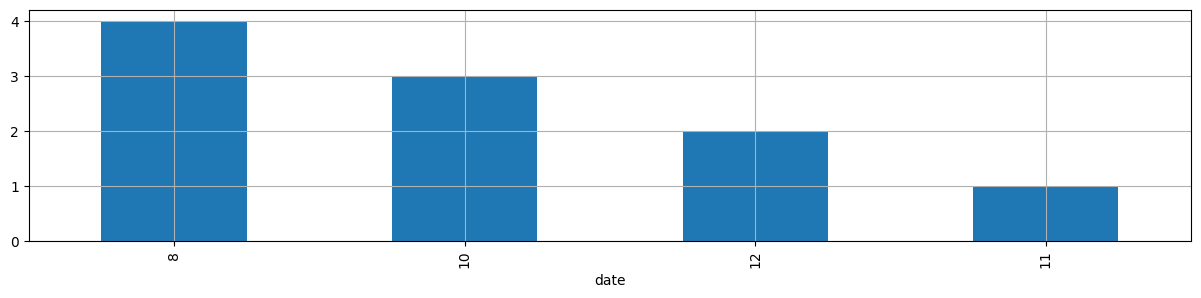

In [299]:
# plot histogram with number of images per month (all images are from 2022)
fig = plt.figure(figsize=(15, 3))
gdf['date'].dt.month.value_counts().plot(kind='bar', ax=fig.gca(), grid=True)
plt.show()


In [300]:
zones = sorted(gdf['zone'].unique())
zone_gdf = gdf[gdf['zone'] == zones[4]]
n = min(5, len(zone_gdf))
sample = zone_gdf.sample(n, random_state=2025)
sample

,json_path,zone,region,date,geometry,s1_matches,s2_matches,num_s1_matches,num_s2_matches
1,data/json/zone=50S/region=712508_7510599/date=...,50S,712508_7510599,2022-10-04,"POLYGON ((119.06952 -22.50128, 119.06947 -22.4...",[],[{'id': 'S2A_MSIL2A_20221005T020451_N0400_R017...,0,2
